# 07 Full model: Extreme Gradient Boosting with TFIDF + complexity features

In [131]:
import time
start = time.time()

import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

import xgboost as xgb
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

import gc

In [132]:
df = pd.read_csv('../data/spanish_corpus_features_v2.csv')

In [133]:
df.head()

,headline,text,n_sentences_text,n_words_text,avg_words_sent_text,avg_word_size_text,ttr_text,n_words_headline,avg_word_size_headline,label
0,sofía castro y alejandro peña pretelini: una i...,sofía castro y alejandro peña pretelini: una i...,5,123,24.600000,6.398374,69.105691,8,7.500000,1
1,un paso más cerca de hacer los exámenes 'online',un paso más cerca de hacer los exámenes 'onlin...,8,224,28.000000,7.205357,77.232143,5,5.800000,1
2,esto es lo que los científicos realmente piens...,esto es lo que los científicos realmente piens...,29,467,16.103448,7.573876,64.668094,4,9.500000,1
3,inicia impresión de boletas para elección pres...,inicia impresión de boletas para elección pres...,10,167,16.700000,7.964072,63.473054,5,8.400000,1
4,a *number* día del mundial,a *number* día del mundial\nfifa.com sigue la ...,4,57,14.250000,7.368421,84.210526,3,5.333333,1


In [134]:
df.shape

(971, 10)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 971 entries, 0 to 970
Data columns (total 10 columns):
headline                  971 non-null object
text                      971 non-null object
n_sentences_text          971 non-null int64
n_words_text              971 non-null int64
avg_words_sent_text       971 non-null float64
avg_word_size_text        971 non-null float64
ttr_text                  971 non-null float64
n_words_headline          971 non-null int64
avg_word_size_headline    971 non-null float64
label                     971 non-null int64
dtypes: float64(4), int64(4), object(2)
memory usage: 76.0+ KB


In [136]:
df.columns

Index(['headline', 'text', 'n_sentences_text', 'n_words_text',
       'avg_words_sent_text', 'avg_word_size_text', 'ttr_text',
       'n_words_headline', 'avg_word_size_headline', 'label'],
      dtype='object')

In [137]:
y = df['label']

## Spanish tokenization

    - Spanish stopwords
    - Added more spanish punctuation
    - Created stems with lemmas, using the rooting word

In [138]:
# stopword list to use
spanish_stopwords = stopwords.words('spanish')

# spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

# punctuation to remove
non_words = list(punctuation)

# adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

def tokenize(text):  
    # remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    # tokenization
    tokens =  word_tokenize(text)

    # stemming
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## TFIDF Vectorizer transformation with the tokenization explaned

In [139]:
tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

text_vectorized = tfidf_vectorizer.fit_transform(df['text'])

tfvocab = tfidf_vectorizer.get_feature_names()

## Make Dense dataframe Sparse, and Combine with TF-IDF features

In [140]:
numerical_features = ['n_sentences_text', 'n_words_text', 'avg_words_sent_text',
       'avg_word_size_text', 'ttr_text', 'n_words_headline','avg_word_size_headline']

X = hstack([csr_matrix(df[numerical_features].values), text_vectorized[0:]])
# X = df[numerical_features]
tfvocab = df[numerical_features].columns.tolist() + tfvocab

for shape in [X]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ", len(tfvocab))

gc.collect();

971 Rows and 15612 Cols
Feature Names Length:  15612


In [141]:
# Calculating level of imbalance for future models.
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]
print("Imbalance Weight: ", imbalance_weight)

Imbalance Weight:  0.9775967413441956


### Split into testing set, training set and validation set

In [142]:
# Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

# Training and Validation Set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.3, random_state = 43)

# XGBOOST Sparse Feature Storage
d_train = xgb.DMatrix(X_train, y_train, feature_names = tfvocab)
d_valid = xgb.DMatrix(X_valid, y_valid, feature_names = tfvocab)
d_test = xgb.DMatrix(X_test, y_test, feature_names = tfvocab)

## XGBoost - eXtreme Gradient Boosting

In [148]:
xgb_params = {'eta': 0.05, 
              'max_depth': 12, 
              'subsample': 0.8, 
              'colsample_bytree': 0.75,
              'min_child_weight' : 1.5,
              'scale_pos_weight': imbalance_weight,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 43,
              'lambda': 1.5,
              'alpha': .6
             }

In [150]:
modelstart = time.time()

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 2000, watchlist, verbose_eval = 40, early_stopping_rounds = 40)

print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart) / 60))

print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	train-auc:0.88568	valid-auc:0.66922
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 40 rounds.
[40]	train-auc:0.99929	valid-auc:0.89312
[80]	train-auc:1.00000	valid-auc:0.89630
[120]	train-auc:1.00000	valid-auc:0.89745
Stopping. Best iteration:
[97]	train-auc:1.00000	valid-auc:0.89938

Model Runtime: 0.07 Minutes
Best error: 0.90 with 98 rounds


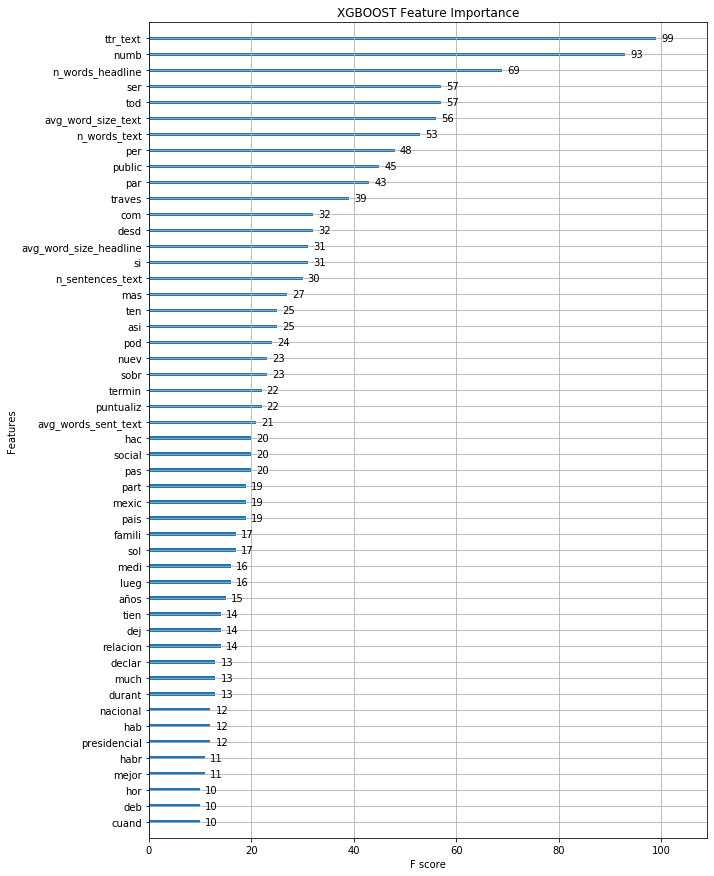

In [151]:
f, ax = plt.subplots(figsize = [10,15])
xgb.plot_importance(model,max_num_features = 50,ax = ax)
plt.title("XGBOOST Feature Importance")
plt.show()

## Predictions & results

In [152]:
y_pred = np.array(model.predict(d_test, ntree_limit = model.best_iteration))
y_pred  = y_pred > 0.5  
y_pred = y_pred.astype(int)

In [153]:
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

Accuracy: 76.71%


In [154]:
cf_matrix = confusion_matrix(y_test,y_pred, labels = [0, 1])
print(cf_matrix)

[[106  44]
 [ 24 118]]


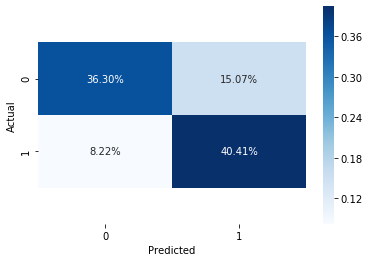

In [155]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

971 Rows and 15613 Cols
Feature Names Length:  15613
[0]	train-auc:0.88841	valid-auc:0.75849
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 40 rounds.
[40]	train-auc:0.99900	valid-auc:0.91034
[80]	train-auc:1.00000	valid-auc:0.90726
Stopping. Best iteration:
[49]	train-auc:0.99941	valid-auc:0.91053

Model Runtime: 0.04 Minutes
Best error: 0.91 with 50 rounds
Accuracy: 78.42%


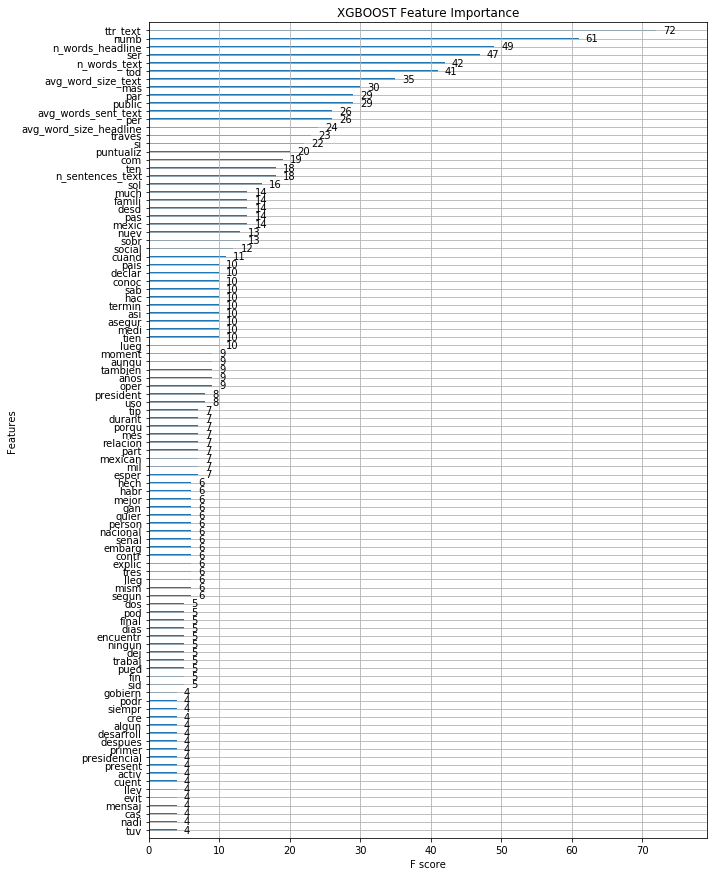

In [170]:
import time
start = time.time()

import itertools
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.data import load  
from nltk.stem import SnowballStemmer  
from string import punctuation

import xgboost as xgb
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

df = pd.read_csv('../data/spanish_corpus_features_v2.csv')


####### TFIDF Transformation to text ########

#Stopword list to use
spanish_stopwords = stopwords.words('spanish')

#Spanish stemmer:
stemmer = SnowballStemmer('spanish')

def stem_tokens(tokens, stemmer):  
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

#Punctuation to remove
non_words = list(punctuation)

#Adding spanish punctuation
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

def tokenize(text):  
    #Remove punctuation
    text = ''.join([c for c in text if c not in non_words])
    #Tokenize
    tokens =  word_tokenize(text)

    #Stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems


tfidf_vectorizer = TfidfVectorizer(  
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = spanish_stopwords)

text_vectorized = tfidf_vectorizer.fit_transform(df['text'])

tfvocab = tfidf_vectorizer.get_feature_names()


####### Combine TF-IDF and dense features #######

numerical_features = ['n_sentences_text', 'n_words_text', 'avg_words_sent_text',
       'avg_word_size_text', 'ttr_text', 'n_words_headline','avg_word_size_headline', 'ttr_headline']

X = hstack([csr_matrix(df[numerical_features].values), text_vectorized[0:]])
# X = df[numerical_features]
tfvocab = df[numerical_features].columns.tolist() + tfvocab

for shape in [X]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ", len(tfvocab))

####### Split data in train, validation and test #######

# Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

# Training and Validation Set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.3, random_state = 43)

# XGBOOST Sparse Feature Storage
d_train = xgb.DMatrix(X_train, y_train, feature_names = tfvocab)
d_valid = xgb.DMatrix(X_valid, y_valid, feature_names = tfvocab)
d_test = xgb.DMatrix(X_test, y_test, feature_names = tfvocab)


####### Model training #######

xgb_params = {'eta': 0.05, 
              'max_depth': 12, 
              'subsample': 0.8, 
              'colsample_bytree': 0.75,
              'min_child_weight' : 1.5,
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 43,
              'lambda': 1.5,
              'alpha': .6
             }

modelstart = time.time()

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 2000, watchlist, verbose_eval = 40, early_stopping_rounds = 40)

print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart) / 60))

print("Best error: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration + 1))


############### RESULTS ################

# accuracy on test prediction

y_pred = np.array(model.predict(d_test, ntree_limit = model.best_iteration))
y_pred  = y_pred > 0.5  
y_pred = y_pred.astype(int)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score * 100, 2)}%')

# feature importance
f, ax = plt.subplots(figsize = [10, 15])
xgb.plot_importance(model, max_num_features = 100, ax = ax)
plt.title("XGBOOST Feature Importance")
plt.show()